In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn import preprocessing
from ydata_profiling import ProfileReport

# №1. Загрузка и предобработка данных

### Загрузите в датафрейм файл autos

In [2]:
autos = pd.read_csv('/Users/olgazdanova/Downloads/autos.csv')
autos.head(3)

dateCrawled                                        name  seller  \
0  2016-03-26 17:47:46            Peugeot_807_160_NAVTECH_ON_BOARD  privat   
1  2016-04-04 13:38:56  BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik  privat   
2  2016-03-26 18:57:24                  Volkswagen_Golf_1.6_United  privat   

  offerType   price vehicleType  yearOfRegistration    gearbox  powerPS  \
0   Angebot  $5,000         bus                2004    manuell      158   
1   Angebot  $8,500   limousine                1997  automatik      286   
2   Angebot  $8,990   limousine                2009    manuell      102   

    model   odometer  monthOfRegistration fuelType       brand  \
0  andere  150,000km                    3      lpg     peugeot   
1     7er  150,000km                    6   benzin         bmw   
2    golf   70,000km                    7   benzin  volkswagen   

  notRepairedDamage  nrOfPictures  postalCode             lastSeen  
0              nein             0       79588  2016-04-06 06:45:54  
1              nein             0       71034  2016-04-06 14:45:08  
2              nein             0       35394  2016-04-06 20:15:37

Датасет autos содержит список объявлений для сайта о продаже подержанных автомобилей

Описание полей датасета:

dateCrawled — дата размещения объявления;

name — заголовок объявления;

seller — тип продавца;

offerType — тип предложения;

price — стоимость в USD;

vehicleType — тип транспортного средства;

yearOfRegistration — год регистрации транспортного средства;

gearbox — тип коробки передач;

powerPS — мощность двигателя;

model — модель;

odometer — пробег;

monthOfRegistration — месяц регистрации транспортного средства;

fuelType — тип топлива;

brand — бренд;

notRepairedDamage — требует ли ремонта?;

nrOfPictures — количество загруженных фотографий;

postalCode — почтовый индекс продавца;

lastSeen — дата последнего просмотра объявления.

### Удалите неинформативные признаки

In [3]:
# исследуем неинформативные признаки, а именно те, в которых >95% значений одинаковые или, наоборот, уникальные

low_information = [] 

# цикл по всем столбцам
for col in autos.columns:
    # наибольшая относительная частота в признаке
    top_freq = autos[col].value_counts(normalize=True).max()
    # доля уникальных значений от размера признака
    nunique_ratio = autos[col].nunique() / autos[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

dateCrawled: 96.43% уникальных значений
seller: 100.0% одинаковых значений
offerType: 100.0% одинаковых значений
nrOfPictures: 100.0% одинаковых значений


Столбцы seller, offertype, nrofpictures подлежат удалению в связи с большим процентом (а именно 100%) одинаковых значений. Удаление этих столбцов не принесет ущерба для дальнейшего анализа данных. Также удалим столбец datecrawled, так как 96.43% уникальных значений + дата размещения объявления не влияет на цену выставляемого на продажу автомобиля.

Помимо прочего я бы удалила такие признаки, как name, lastseen и postalcode, так как они не несут значимой информации для анализа рынка подержанных автомобилей. Name повторяет информацию из столбцов brand, model и fueltype (их мы оставим), а lastseen и postalcode просто не несут никакой информации о важных взаимосвязей.

In [4]:
autos_c = autos.copy()
# удаляем неинформативные признаки
autos_copy = autos_c.drop(columns=['dateCrawled', 'seller', 'offerType', 'nrOfPictures', 'name', 'lastSeen', 'postalCode'])
autos_copy.head(3)

price vehicleType  yearOfRegistration    gearbox  powerPS   model  \
0  $5,000         bus                2004    manuell      158  andere   
1  $8,500   limousine                1997  automatik      286     7er   
2  $8,990   limousine                2009    manuell      102    golf   

    odometer  monthOfRegistration fuelType       brand notRepairedDamage  
0  150,000km                    3      lpg     peugeot              nein  
1  150,000km                    6   benzin         bmw              nein  
2   70,000km                    7   benzin  volkswagen              nein

In [5]:
autos_copy.shape

(50000, 11)

После удаления неинформативных признаков имеем 11 столбцов и 50.000 строк

### Очистите датасет от выбросов

Будем искать выбросы в данных с помощью метода межквартильного размаха (метода Тьюки). Он сработает только для числовых данных, поэтому столбцы price, odometer нужно будет перевести из object в float.

In [6]:
# избавляемся от знаков, которые не относятся к цифрам
autos_copy['price'] = autos_copy['price'].str.replace(r'\D', '', regex = True)
# сразу переводим данные от строковых к вещественным
autos_copy['price'] = autos_copy['price'].astype(float)

# аналогично поступаем со столбцом odometer
autos_copy['odometer'] = autos_copy['odometer'].str.replace(r'\D', '', regex = True)
autos_copy['odometer'] = autos_copy['odometer'].astype(float)
autos_copy.head(3)

price vehicleType  yearOfRegistration    gearbox  powerPS   model  \
0  5000.0         bus                2004    manuell      158  andere   
1  8500.0   limousine                1997  automatik      286     7er   
2  8990.0   limousine                2009    manuell      102    golf   

   odometer  monthOfRegistration fuelType       brand notRepairedDamage  
0  150000.0                    3      lpg     peugeot              nein  
1  150000.0                    6   benzin         bmw              nein  
2   70000.0                    7   benzin  volkswagen              nein

In [7]:
autos_copy.describe()

price  yearOfRegistration       powerPS       odometer  \
count  5.000000e+04        50000.000000  50000.000000   50000.000000   
mean   9.840044e+03         2005.073280    116.355920  125732.700000   
std    4.811044e+05          105.712813    209.216627   40042.211706   
min    0.000000e+00         1000.000000      0.000000    5000.000000   
25%    1.100000e+03         1999.000000     70.000000  125000.000000   
50%    2.950000e+03         2003.000000    105.000000  150000.000000   
75%    7.200000e+03         2008.000000    150.000000  150000.000000   
max    1.000000e+08         9999.000000  17700.000000  150000.000000   

       monthOfRegistration  
count         50000.000000  
mean              5.723360  
std               3.711984  
min               0.000000  
25%               3.000000  
50%               6.000000  
75%               9.000000  
max              12.000000

In [8]:
# напишем функцию для работы метода межквартильного размаха
def remove_outliers_iqr(data, columns):
    for col in columns:
        # вычисляем квартили
        quartile_1, quartile_3 = data[col].quantile(0.25), data[col].quantile(0.75),
        # вычисляем межквартильное расстояние
        iqr = quartile_3 - quartile_1
        # вычисляем границы Тьюки
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        # обозначаем выбросы и очищенные данные, это же и выводим
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

In [9]:
# создадим список числовых переменных
numerics = ['price', 'yearOfRegistration', 'powerPS', 'odometer', 'monthOfRegistration']
# очистим датасет от выбросов 
autos_cleaned = remove_outliers_iqr(autos_copy, numerics)
autos_cleaned.shape

(38636, 11)

In [10]:
# избавимся от нулей в признаке Цена, так как такая цена маловероятна
mod = autos_cleaned['price'].median()
autos_cleaned['price'].replace(0, mod, inplace=True)

/var/folders/50/18ts1bh12532xjz2xv95cl540000gn/T/ipykernel_15253/3295974528.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  autos_cleaned['price'].replace(0, mod, inplace=True)


In [11]:
# избавляемся от нулей в признаке Мощность
mod = autos_cleaned['powerPS'].median()
autos_cleaned['powerPS'].replace(0, mod, inplace=True)

/var/folders/50/18ts1bh12532xjz2xv95cl540000gn/T/ipykernel_15253/3305501166.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  autos_cleaned['powerPS'].replace(0, mod, inplace=True)


In [12]:
# избавляемся от нулей в признаке Месяц регистрации
mod = autos_cleaned['monthOfRegistration'].median()
autos_cleaned['monthOfRegistration'].replace(0, mod, inplace=True)

/var/folders/50/18ts1bh12532xjz2xv95cl540000gn/T/ipykernel_15253/4201348878.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  autos_cleaned['monthOfRegistration'].replace(0, mod, inplace=True)


In [13]:
autos_cleaned.shape

(38636, 11)

После удаления выбросов имеем 11 столбцов и 38.636 строк

In [14]:
# удалим дубликаты
autos_cleaned = autos_cleaned.drop_duplicates()
autos_cleaned.shape

(38017, 11)

После удаления дубликатов имеем 11 столбцов и 38.017 строк

# №2. Работа с пропущенными значениями

In [15]:
autos_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38017 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                38017 non-null  float64
 1   vehicleType          33936 non-null  object 
 2   yearOfRegistration   38017 non-null  int64  
 3   gearbox              36140 non-null  object 
 4   powerPS              38017 non-null  int64  
 5   model                36043 non-null  object 
 6   odometer             38017 non-null  float64
 7   monthOfRegistration  38017 non-null  int64  
 8   fuelType             34485 non-null  object 
 9   brand                38017 non-null  object 
 10  notRepairedDamage    30049 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 3.5+ MB


In [16]:
# изучим частоту пропусков по признакам
nulls = autos_cleaned.isnull().mean()*100
cols_with_null = nulls[nulls>0].sort_values(ascending=False)
cols_with_null

notRepairedDamage    20.959045
vehicleType          10.734671
fuelType              9.290581
model                 5.192414
gearbox               4.937265
dtype: float64

Больше всего пропусков наблюдается в столбце notRepairedDamage (требует ли ремонта), однако признаки мы обычно удаляем, если процент пропусков > 30-40%, поэтому в данном случае пропуски заменим модальным значением. На втором месте - vehicleType (тип транспортного средства) - также заменим на моду. И оставшиеся три признака заменим на моду. Однако перед тем как заменять проверим строки на информативность. Если в строке будет 2 пропуска и больше, удалим ее.

In [17]:
m = autos_cleaned.shape[1]
# удаляем строку, если в ней больше 2 пропусков
autos_without_nulls = autos_cleaned.dropna(thresh=m-2, axis=0)

In [18]:
autos_without_nulls.shape

(36225, 11)

После удаления строк, в которых более двух пропусков, имеем 11 столбцов и 36.225 строк

In [19]:
#создаем словарь 'имя_столбца': число (признак), на который надо заменить пропуски 
values = {
    'notRepairedDamage': autos_without_nulls['notRepairedDamage'].mode()[0],
    'vehicleType': autos_without_nulls['vehicleType'].mode()[0],
    'fuelType': autos_without_nulls['fuelType'].mode()[0],
    'model': autos_without_nulls['model'].mode()[0],
    'gearbox': autos_without_nulls['gearbox'].mode()[0]
}
#заполняем оставшиеся записи константами в соответствии со словарем values
autos_without_nulls = autos_without_nulls.fillna(values)
display(autos_without_nulls.isnull().mean())

price                  0.0
vehicleType            0.0
yearOfRegistration     0.0
gearbox                0.0
powerPS                0.0
model                  0.0
odometer               0.0
monthOfRegistration    0.0
fuelType               0.0
brand                  0.0
notRepairedDamage      0.0
dtype: float64

После всех преобразований в датафрейме не осталось пропусков

# №3. Анализ числовых признаков 

### Рассчитайте основные статистические показатели: среднее, медиану, моду, минимум, максимум

In [20]:
autos_without_nulls.describe()

price  yearOfRegistration       powerPS       odometer  \
count  36225.000000        36225.000000  36225.000000   36225.000000   
mean    3567.296398         2002.583658    115.131401  142255.210490   
std     3402.036105            5.809928     42.618710   16542.484972   
min        1.000000         1987.000000      1.000000   90000.000000   
25%     1100.000000         1999.000000     82.000000  150000.000000   
50%     2300.000000         2002.000000    105.000000  150000.000000   
75%     4950.000000         2006.000000    140.000000  150000.000000   
max    16350.000000         2019.000000    247.000000  150000.000000   

       monthOfRegistration  
count         36225.000000  
mean              6.357295  
std               3.213407  
min               1.000000  
25%               4.000000  
50%               6.000000  
75%               9.000000  
max              12.000000

### Визуализируйте распределение числовых переменных с помощью гистограмм и «ящиков с усами»

In [21]:
# функция для удобной визулизации признаков 

def show_distribution(data, variables):
    ncols = len(variables)

    fig_length = 5 * ncols

    fig, axes = plt.subplots(2, ncols, figsize=(fig_length, fig_length // 2.5))
    
    for index, variable in enumerate(variables):
        data_variable = data[variable].dropna(ignore_index=True)
        
        variable_mean = data_variable.mean()
        variable_median = data_variable.median()
        
        ## histogram
        axes[0, index].hist(data_variable, edgecolor='black', bins=20, color='darkblue', alpha=.3)
        axes[0, index].set_title(variable)
    
        # add vertical lines for mean and median
        axes[0, index].axvline(variable_mean, color='red', label='mean')  # default linestyle is 'solid'
        axes[0, index].axvline(variable_median, color='orange', linestyle='dashed', label='median')  # for horizontal line use axhline
            # (coordinate Y)
    
        if index == 0:
            axes[0, index].set_ylabel('histogram')
    
        # add legend
        if index == ncols - 1:
            axes[0, index].legend()
    
        ## boxplot
        axes[1, index].boxplot(data_variable, vert=False)
        axes[1, index].set_yticks([])
    
        if index == 0:
            axes[1, index].set_ylabel('boxplot')

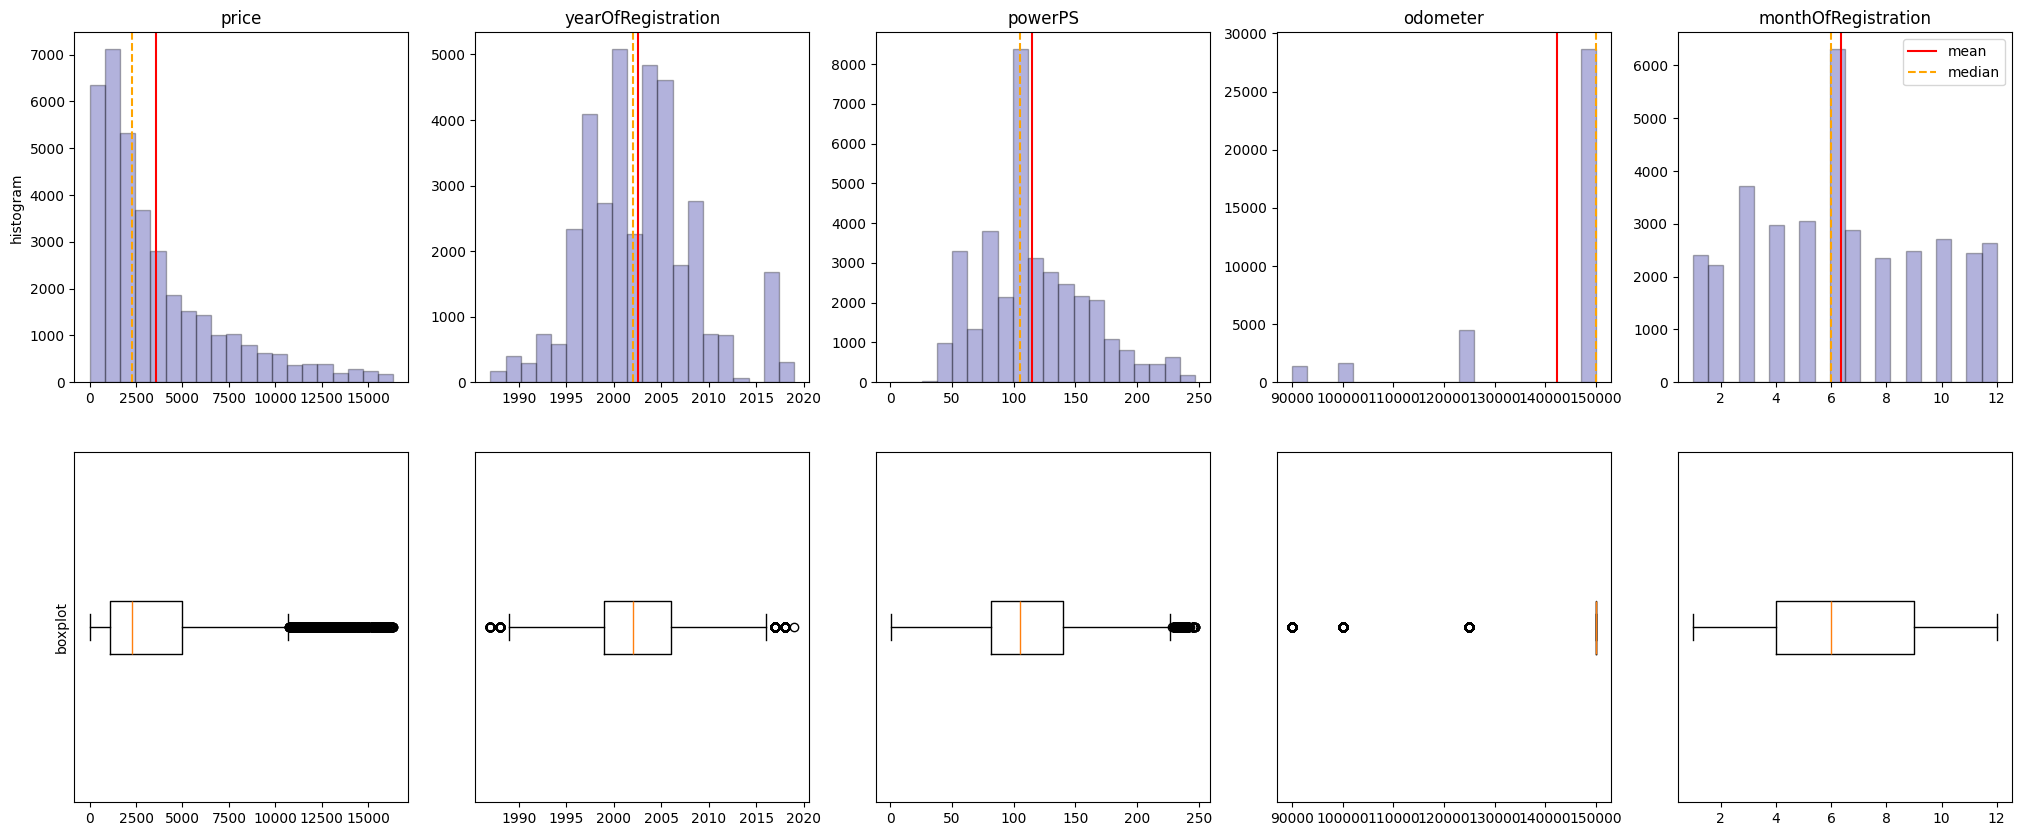

In [22]:
# визуализируем распределение числовых переменных
show_distribution(autos_without_nulls, numerics)

# №4. Анализ категориальных признаков

### Определите моду и частотность для 1–2 категориальных признаков

In [23]:
autos_without_nulls[['fuelType', 'vehicleType']].describe()

fuelType vehicleType
count     36225       36225
unique        7           8
top      benzin   limousine
freq      24344       12279

### Рассчитайте доли значений в процентах и визуализируйте их с помощью круговой диаграммы (pie() из matplotlib или аналог)

In [24]:
fueltype_counts = autos_without_nulls['fuelType'].value_counts(normalize=True)*100
fueltype_counts

fuelType
benzin     67.202208
diesel     31.017253
lpg         1.548654
cng         0.157350
hybrid      0.049689
andere      0.019324
elektro     0.005521
Name: proportion, dtype: float64

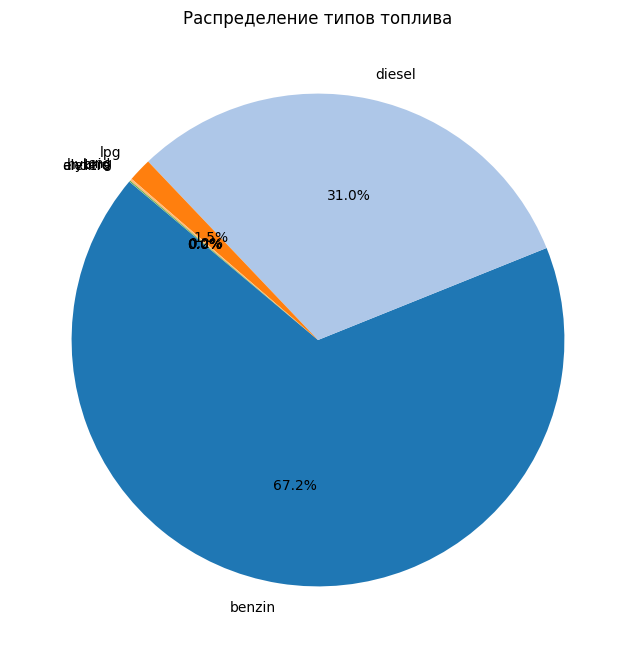

In [25]:
labels = fueltype_counts.index
sizes = fueltype_counts.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)

plt.title('Распределение типов топлива')

plt.show();

Так как категории помимо бензина и дизеля встречаются крайне редко (<2 %) и на графике сливаются в одну, можно их заранее объединить в категорию "Other", чтобы график был более приятен глазу

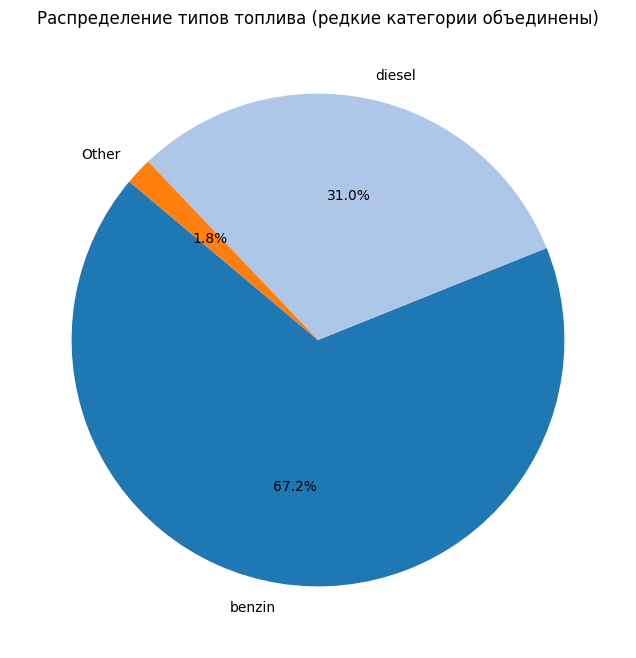

In [26]:
# объединяем редкие категории
threshold = 2  # порог для объединения
small_categories = fueltype_counts[fueltype_counts < threshold]
other_percentage = small_categories.sum()  # суммируем проценты редких категорий

# создаем новый набор данных
filtered_counts = fueltype_counts[fueltype_counts >= threshold]
filtered_counts['Other'] = other_percentage  # добавляем группу "Other"

labels = filtered_counts.index
sizes = filtered_counts.values 

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)

# Добавляем заголовок
plt.title('Распределение типов топлива (редкие категории объединены)')

# Показываем график
plt.show();

In [27]:
# аналогичным образом делаем круговую диаграмму для признака vehicletype
vehicletype_counts = autos_without_nulls['vehicleType'].value_counts(normalize=True)*100
vehicletype_counts

vehicleType
limousine     33.896480
kleinwagen    22.846101
kombi         21.178744
bus            9.046239
cabrio         5.156660
coupe          4.121463
suv            2.917874
andere         0.836439
Name: proportion, dtype: float64

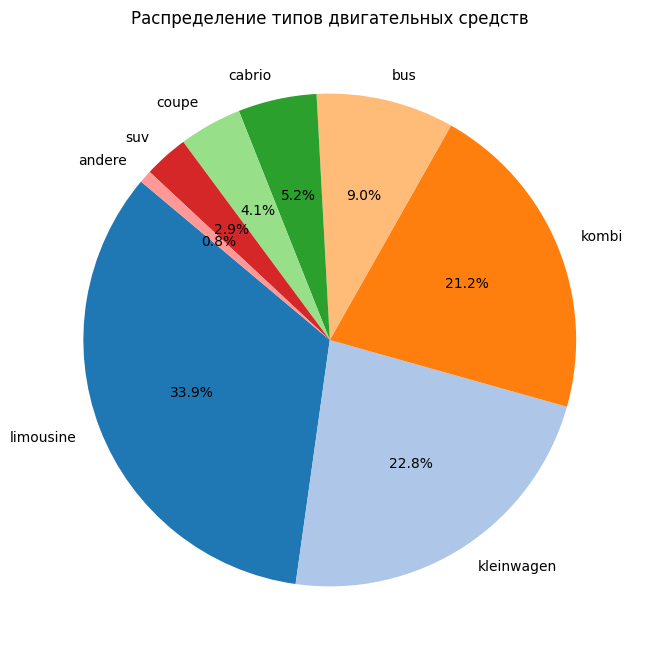

In [28]:
labels = vehicletype_counts.index
sizes = vehicletype_counts.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)

plt.title('Распределение типов двигательных средств')

plt.show();

Получился более читабельный график, поэтому нет необходимости объединять маленькие категории в одну

# №5. Корреляционный анализ числовых признаков

### Постройте тепловую карту корреляции для признаков: цена, год регистрации, мощность, пробег

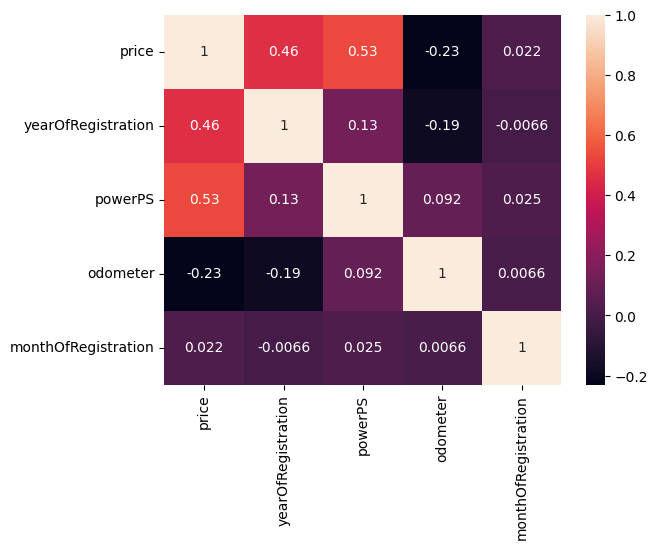

In [29]:
sns.heatmap(autos_without_nulls[numerics].corr(), annot=True);

### Определите, какие из этих признаков наиболее коррелируют

Наиболее коррелируют признаки powerPS (мощность) и price (цена), коэффициент корреляции 0.53 - связь прямая, средняя по силе. Все остальные признаки имеют меньшие коэффициенты корреляции.

# №6. Анализ категориальных признаков и кодирование

### Создайте новый признак «Период регистрации» на основе года и месяца регистрации

In [30]:
autos_without_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36225 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                36225 non-null  float64
 1   vehicleType          36225 non-null  object 
 2   yearOfRegistration   36225 non-null  int64  
 3   gearbox              36225 non-null  object 
 4   powerPS              36225 non-null  int64  
 5   model                36225 non-null  object 
 6   odometer             36225 non-null  float64
 7   monthOfRegistration  36225 non-null  int64  
 8   fuelType             36225 non-null  object 
 9   brand                36225 non-null  object 
 10  notRepairedDamage    36225 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 3.3+ MB


In [31]:
# cоздаем новый признак "Период регистрации"
autos_without_nulls['registration_period'] = autos_without_nulls['yearOfRegistration'].astype(str) + '-' + autos_without_nulls['monthOfRegistration'].astype(str).str.zfill(2)

autos_without_nulls.head()

price vehicleType  yearOfRegistration    gearbox  powerPS    model  \
0  5000.0         bus                2004    manuell      158   andere   
4  1350.0       kombi                2003    manuell      104    focus   
5  7900.0         bus                2006  automatik      150  voyager   
6   300.0   limousine                1995    manuell       90     golf   
7  1990.0   limousine                1998    manuell       90     golf   

   odometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0  150000.0                    3      lpg     peugeot              nein   
4  150000.0                    7   benzin        ford              nein   
5  150000.0                    4   diesel    chrysler              nein   
6  150000.0                    8   benzin  volkswagen              nein   
7  150000.0                   12   diesel  volkswagen              nein   

  registration_period  
0             2004-03  
4             2003-07  
5             2006-04  
6             1995-08  
7             1998-12

### Определите подходящий метод кодирования для этого признака и реализуйте его

In [32]:
autos_without_nulls['registration_period'].nunique()

369

В рамках курса мы изучили три метода кодирования - Ordinal Encoding (не подходит, так как период регистрации не порядковая величина), OneHot Encoding (не подходит, так как у этого номинального признака > 15 значений, а именно 369) и Binary Encoding. Выберем последний, так как он позволит избавиться от проклятия размерности и закодирует наши данные.

In [33]:
bin_encoder = ce.BinaryEncoder(cols=['registration_period'])
type_bin = bin_encoder.fit_transform(autos_without_nulls['registration_period'])
autos_without_nulls = pd.concat([autos_without_nulls, type_bin], axis=1)

autos_without_nulls.head()

price vehicleType  yearOfRegistration    gearbox  powerPS    model  \
0  5000.0         bus                2004    manuell      158   andere   
4  1350.0       kombi                2003    manuell      104    focus   
5  7900.0         bus                2006  automatik      150  voyager   
6   300.0   limousine                1995    manuell       90     golf   
7  1990.0   limousine                1998    manuell       90     golf   

   odometer  monthOfRegistration fuelType       brand  ...  \
0  150000.0                    3      lpg     peugeot  ...   
4  150000.0                    7   benzin        ford  ...   
5  150000.0                    4   diesel    chrysler  ...   
6  150000.0                    8   benzin  volkswagen  ...   
7  150000.0                   12   diesel  volkswagen  ...   

  registration_period registration_period_0  registration_period_1  \
0             2004-03                     0                      0   
4             2003-07                     0                      0   
5             2006-04                     0                      0   
6             1995-08                     0                      0   
7             1998-12                     0                      0   

   registration_period_2  registration_period_3  registration_period_4  \
0                      0                      0                      0   
4                      0                      0                      0   
5                      0                      0                      0   
6                      0                      0                      0   
7                      0                      0                      0   

   registration_period_5  registration_period_6  registration_period_7  \
0                      0                      0                      0   
4                      0                      0                      1   
5                      0                      0                      1   
6                      0                      1                      0   
7                      0                      1                      0   

   registration_period_8  
0                      1  
4                      0  
5                      1  
6                      0  
7                      1  

[5 rows x 21 columns]

### Выберите метод кодирования для признака «Тип автомобиля» и примените его

In [34]:
autos_without_nulls['vehicleType'].nunique()

8

Так как у данного признака 8 различных значений, воспользуемся методом кодирования OneHot Encoding

In [35]:
autos_without_nulls = pd.get_dummies(autos_without_nulls, columns=['vehicleType'])
autos_without_nulls.head()

price  yearOfRegistration    gearbox  powerPS    model  odometer  \
0  5000.0                2004    manuell      158   andere  150000.0   
4  1350.0                2003    manuell      104    focus  150000.0   
5  7900.0                2006  automatik      150  voyager  150000.0   
6   300.0                1995    manuell       90     golf  150000.0   
7  1990.0                1998    manuell       90     golf  150000.0   

   monthOfRegistration fuelType       brand notRepairedDamage  ...  \
0                    3      lpg     peugeot              nein  ...   
4                    7   benzin        ford              nein  ...   
5                    4   diesel    chrysler              nein  ...   
6                    8   benzin  volkswagen              nein  ...   
7                   12   diesel  volkswagen              nein  ...   

  registration_period_7  registration_period_8  vehicleType_andere  \
0                     0                      1               False   
4                     1                      0               False   
5                     1                      1               False   
6                     0                      0               False   
7                     0                      1               False   

   vehicleType_bus  vehicleType_cabrio  vehicleType_coupe  \
0             True               False              False   
4            False               False              False   
5             True               False              False   
6            False               False              False   
7            False               False              False   

   vehicleType_kleinwagen  vehicleType_kombi  vehicleType_limousine  \
0                   False              False                  False   
4                   False               True                  False   
5                   False              False                  False   
6                   False              False                   True   
7                   False              False                   True   

   vehicleType_suv  
0            False  
4            False  
5            False  
6            False  
7            False  

[5 rows x 28 columns]

### Рассчитайте корреляцию между этими двумя категориальными признаками

Посмотрим на корреляцию между признаком Период регистрации и Тип автомобиля

In [36]:
# создадим отдельный датафрейм с закодированными признаками период регистрации и тип автомобилей
reg_veh = autos_without_nulls[['registration_period_0', 'registration_period_1',
       'registration_period_2', 'registration_period_3',
       'registration_period_4', 'registration_period_5',
       'registration_period_6', 'registration_period_7',
       'registration_period_8', 'vehicleType_andere', 'vehicleType_bus',
       'vehicleType_cabrio', 'vehicleType_coupe', 'vehicleType_kleinwagen',
       'vehicleType_kombi', 'vehicleType_limousine', 'vehicleType_suv']]
display(reg_veh)

registration_period_0  registration_period_1  registration_period_2  \
0                          0                      0                      0   
4                          0                      0                      0   
5                          0                      0                      0   
6                          0                      0                      0   
7                          0                      0                      0   
...                      ...                    ...                    ...   
49991                      0                      0                      0   
49992                      0                      0                      1   
49993                      0                      0                      0   
49996                      0                      0                      1   
49999                      0                      1                      1   

       registration_period_3  registration_period_4  registration_period_5  \
0                          0                      0                      0   
4                          0                      0                      0   
5                          0                      0                      0   
6                          0                      0                      0   
7                          0                      0                      0   
...                      ...                    ...                    ...   
49991                      1                      0                      1   
49992                      0                      1                      0   
49993                      0                      0                      0   
49996                      1                      1                      1   
49999                      0                      0                      0   

       registration_period_6  registration_period_7  registration_period_8  \
0                          0                      0                      1   
4                          0                      1                      0   
5                          0                      1                      1   
6                          1                      0                      0   
7                          1                      0                      1   
...                      ...                    ...                    ...   
49991                      0                      0                      0   
49992                      1                      1                      0   
49993                      1                      1                      1   
49996                      1                      1                      0   
49999                      1                      0                      1   

       vehicleType_andere  vehicleType_bus  vehicleType_cabrio  \
0                   False             True               False   
4                   False            False               False   
5                   False             True               False   
6                   False            False               False   
7                   False            False               False   
...                   ...              ...                 ...   
49991               False            False               False   
49992               False            False               False   
49993               False            False               False   
49996               False            False                True   
49999               False            False               False   

       vehicleType_coupe  vehicleType_kleinwagen  vehicleType_kombi  \
0                  False                   False              False   
4                  False                   False               True   
5                  False                   False              False   
6                  False                   False              False   
7                  False                   False

In [37]:
cor_df = reg_veh.corr()
cor_df

registration_period_0  registration_period_1  \
registration_period_0                1.000000              -0.205832   
registration_period_1               -0.205832               1.000000   
registration_period_2               -0.136122              -0.029772   
registration_period_3               -0.074565              -0.041186   
registration_period_4               -0.016105               0.000475   
registration_period_5               -0.006015               0.032268   
registration_period_6               -0.064683              -0.045528   
registration_period_7                0.021537               0.013391   
registration_period_8               -0.015019              -0.025643   
vehicleType_andere                   0.012914              -0.002118   
vehicleType_bus                     -0.004793               0.018695   
vehicleType_cabrio                  -0.002136               0.001252   
vehicleType_coupe                    0.018973               0.000046   
vehicleType_kleinwagen              -0.047626              -0.019153   
vehicleType_kombi                   -0.036701               0.007328   
vehicleType_limousine                0.066400              -0.002383   
vehicleType_suv                      0.002727               0.004275   

                        registration_period_2  registration_period_3  \
registration_period_0               -0.136122              -0.074565   
registration_period_1               -0.029772              -0.041186   
registration_period_2                1.000000              -0.012820   
registration_period_3               -0.012820               1.000000   
registration_period_4               -0.067921              -0.035306   
registration_period_5               -0.062087              -0.076614   
registration_period_6               -0.031060               0.024550   
registration_period_7                0.019356               0.047477   
registration_period_8               -0.053341              -0.055857   
vehicleType_andere                  -0.008342              -0.006267   
vehicleType_bus                      0.009568              -0.004359   
vehicleType_cabrio                   0.002567              -0.002048   
vehicleType_coupe                    0.003463              -0.004680   
vehicleType_kleinwagen               0.012028              -0.019743   
vehicleType_kombi                   -0.007687              -0.009157   
vehicleType_limousine               -0.013284               0.028282   
vehicleType_suv                      0.006762               0.010975   

                        registration_period_4  registration_period_5  \
registration_period_0               -0.016105              -0.006015   
registration_period_1                0.000475               0.032268   
registration_period_2               -0.067921              -0.062087   
registration_period_3               -0.035306              -0.076614   
registration_period_4                1.000000               0.045505   
registration_period_5                0.045505               1.000000   
registration_period_6                0.060532              -0.037692   
registration_period_7               -0.058768              -0.017977   
registration_period_8               -0.004369               0.070124   
vehicleType_andere                  -0.005004               0.007015   
vehicleType_bus                     -0.004827              -0.034997   
vehicleType_cabrio                  -0.020010              -0.014682   
vehicleType_coupe                    0.010006               0.009575   
vehicleType_kleinwagen               0.024406               0.008333   
vehicleType_kombi                    0.027712              -0.037825   
vehicleType_limousine               -0.035530               0.058554   
vehicleType_suv                     -0.002818              -0.029813   

                        registration_period_6  registration_period_7  \
registration_period_0               -0.064683               0

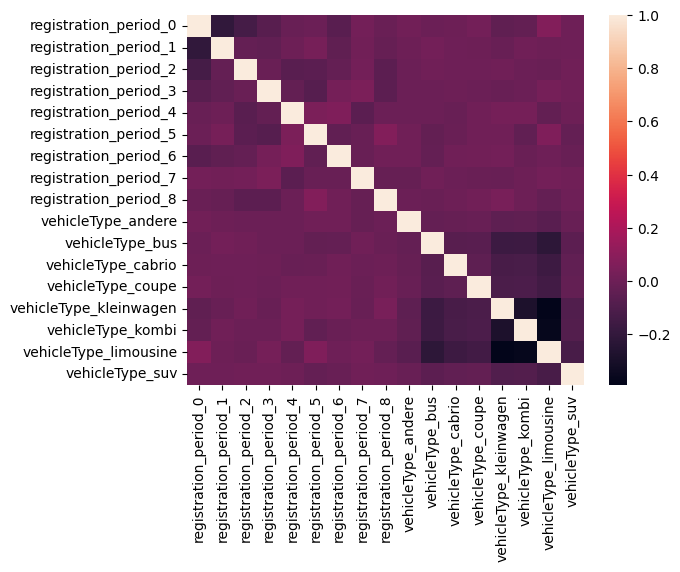

In [38]:
sns.heatmap(cor_df);

### Попробуйте найти корреляцию среди других категориальных признаков

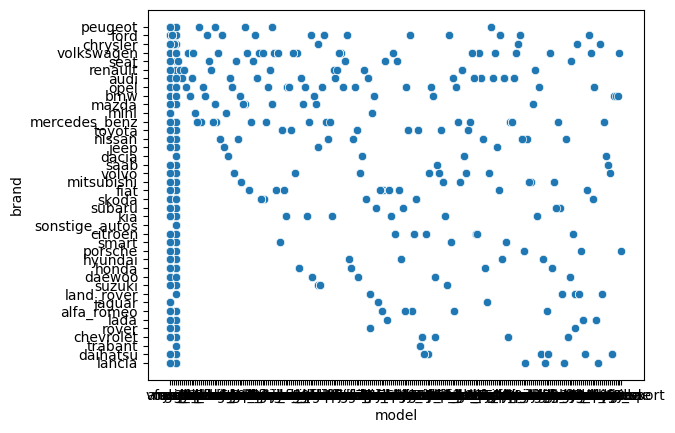

In [39]:
# между моделью и брэндом
sns.scatterplot(data=autos_without_nulls, x="model", y="brand");

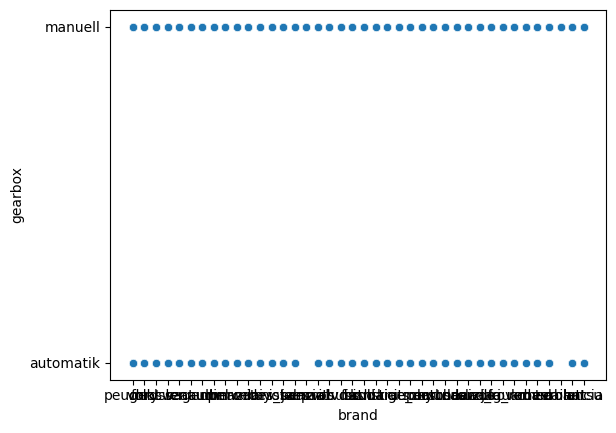

In [40]:
# между брэндом и коробкой передач
sns.scatterplot(data=autos_without_nulls, x="brand", y="gearbox");

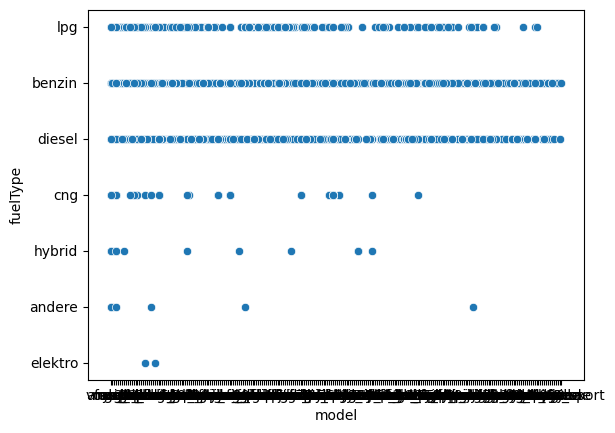

In [41]:
# между моделью и типом топлива
sns.scatterplot(data=autos_without_nulls, x="model", y="fuelType");

Корреляция между категориальными признаками не выявлена

# №7. Нормализация и стандартизация

### Определите, какое преобразование подходит для каждого числового признака: нормализация, стандартизация или ничего не требуется

In [42]:
numerics = ['price', 'yearOfRegistration', 'powerPS', 'odometer', 'monthOfRegistration']
df_n = autos_without_nulls[numerics]
df_n.head()

price  yearOfRegistration  powerPS  odometer  monthOfRegistration
0  5000.0                2004      158  150000.0                    3
4  1350.0                2003      104  150000.0                    7
5  7900.0                2006      150  150000.0                    4
6   300.0                1995       90  150000.0                    8
7  1990.0                1998       90  150000.0                   12

Прежде чем применять преобразование числовых признаков, нужно понять распределены они нормально или нет

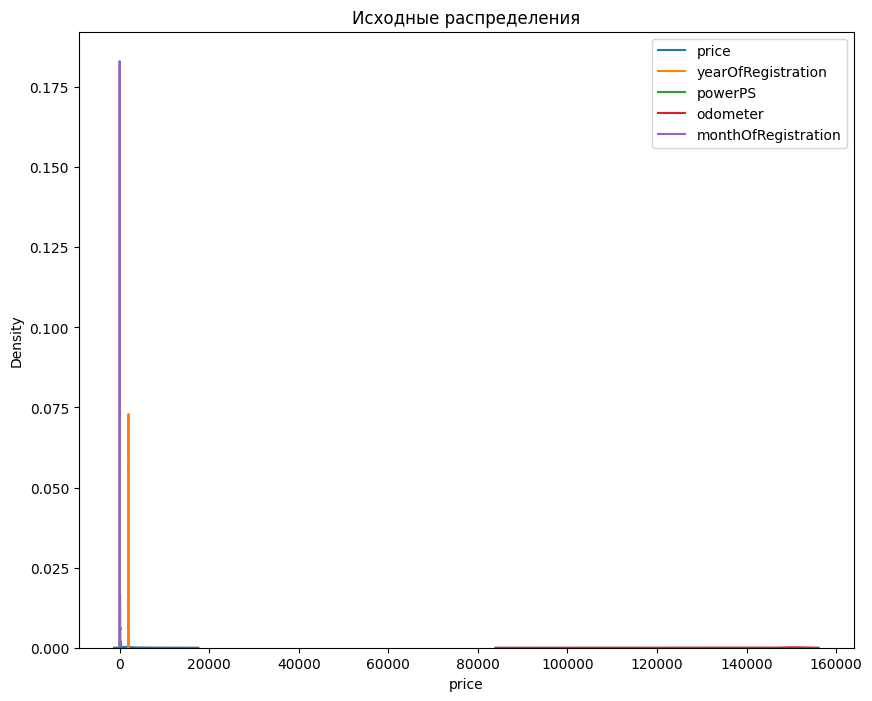

In [43]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df_n['price'], ax=ax1, label ='price')
sns.kdeplot(df_n['yearOfRegistration'], ax=ax1, label ='yearOfRegistration')
sns.kdeplot(df_n['powerPS'], ax=ax1, label ='powerPS')
sns.kdeplot(df_n['odometer'], ax=ax1, label ='odometer')
sns.kdeplot(df_n['monthOfRegistration'], ax=ax1, label ='monthOfRegistration')
plt.legend();

### Для проверки распределения используйте гистограммы

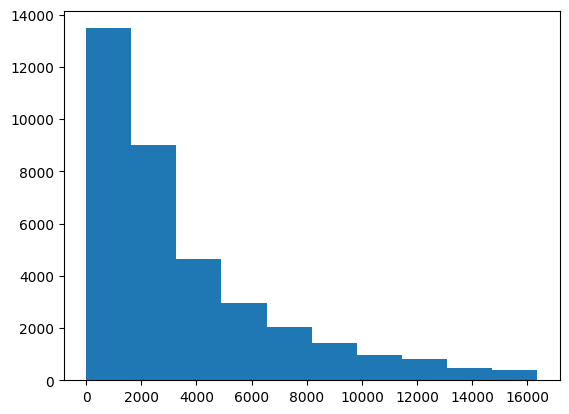

In [44]:
plt.hist(autos_without_nulls['price']);

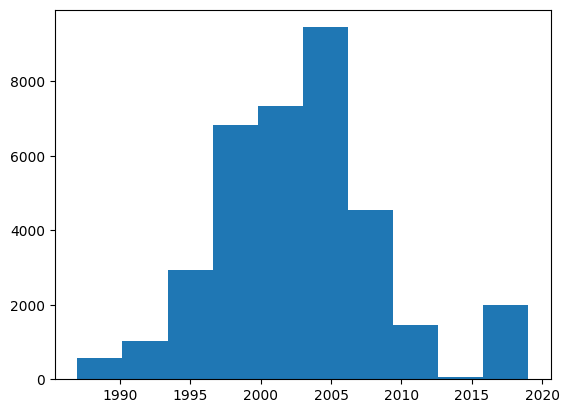

In [45]:
plt.hist(autos_without_nulls['yearOfRegistration']);

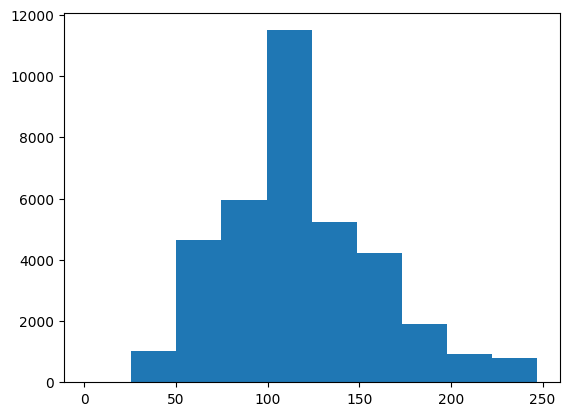

In [46]:
plt.hist(autos_without_nulls['powerPS']);

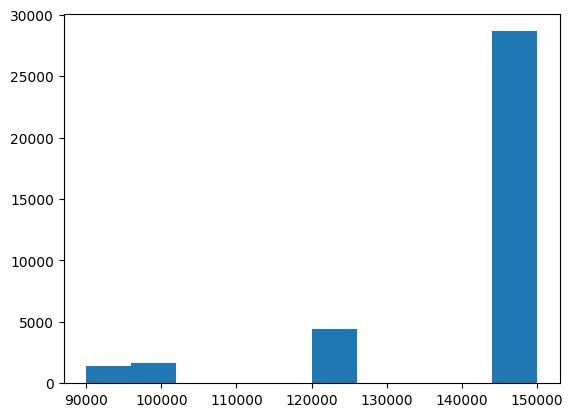

In [47]:
plt.hist(autos_without_nulls['odometer']);

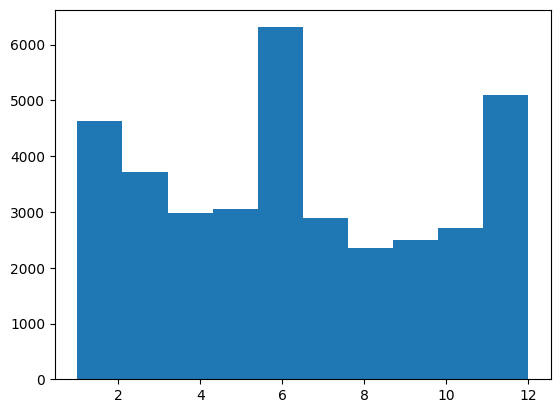

In [48]:
plt.hist(autos_without_nulls['monthOfRegistration']);

In [49]:
df_n.describe()

price  yearOfRegistration       powerPS       odometer  \
count  36225.000000        36225.000000  36225.000000   36225.000000   
mean    3567.296398         2002.583658    115.131401  142255.210490   
std     3402.036105            5.809928     42.618710   16542.484972   
min        1.000000         1987.000000      1.000000   90000.000000   
25%     1100.000000         1999.000000     82.000000  150000.000000   
50%     2300.000000         2002.000000    105.000000  150000.000000   
75%     4950.000000         2006.000000    140.000000  150000.000000   
max    16350.000000         2019.000000    247.000000  150000.000000   

       monthOfRegistration  
count         36225.000000  
mean              6.357295  
std               3.213407  
min               1.000000  
25%               4.000000  
50%               6.000000  
75%               9.000000  
max              12.000000

Видим, что данные распределены не нормально, поэтому воспользуемся методом нормализации

In [50]:
col_names = list(df_n.columns)

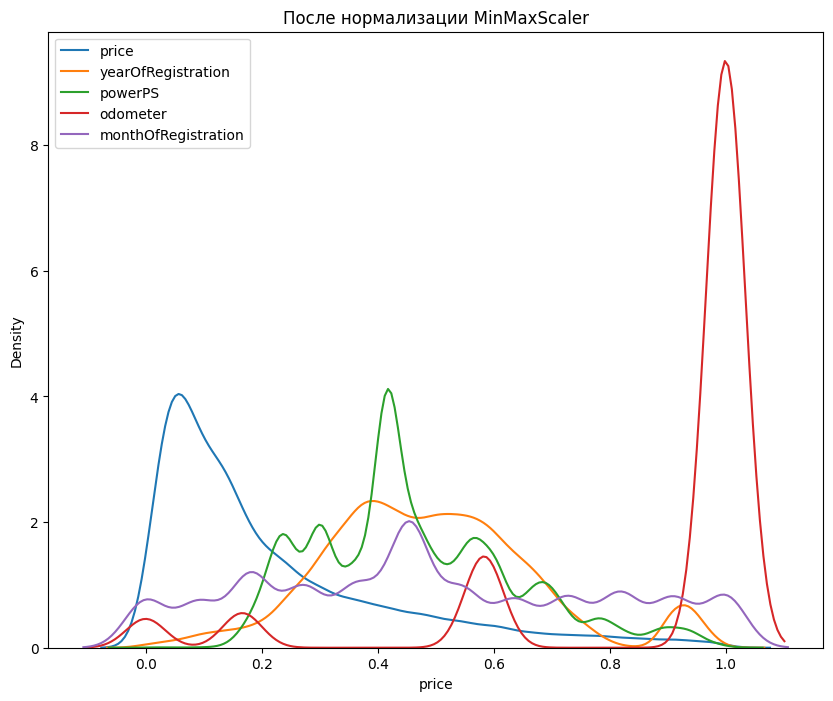

In [51]:
# для нормализации сейчас будем использовать MinMaxScaler

# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# копируем исходный датасет
df_mm = mm_scaler.fit_transform(df_n)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('После нормализации MinMaxScaler')

sns.kdeplot(df_mm['price'], ax=ax1, label ='price')
sns.kdeplot(df_mm['yearOfRegistration'], ax=ax1, label ='yearOfRegistration')
sns.kdeplot(df_mm['powerPS'], ax=ax1, label ='powerPS')
sns.kdeplot(df_mm['odometer'], ax=ax1, label ='odometer')
sns.kdeplot(df_mm['monthOfRegistration'], ax=ax1, label ='monthOfRegistration')
plt.legend();

In [52]:
df_mm.describe()

price  yearOfRegistration       powerPS      odometer  \
count  36225.000000        36225.000000  36225.000000  36225.000000   
mean       0.218135            0.486989      0.463949      0.870920   
std        0.208088            0.181560      0.173247      0.275708   
min        0.000000            0.000000      0.000000      0.000000   
25%        0.067221            0.375000      0.329268      1.000000   
50%        0.140620            0.468750      0.422764      1.000000   
75%        0.302710            0.593750      0.565041      1.000000   
max        1.000000            1.000000      1.000000      1.000000   

       monthOfRegistration  
count         36225.000000  
mean              0.487027  
std               0.292128  
min               0.000000  
25%               0.272727  
50%               0.454545  
75%               0.727273  
max               1.000000

Видим, что теперь все значения теперь находятся в интервале от 0 до 1 включительно.

# №8. Разведочный анализ данных

### Сравните очищенный и исходный датасеты с помощью библиотек ydata-profiling, sweetviz, dtale

In [53]:
# исходный датасет
autos_original = pd.read_csv('/Users/olgazdanova/Downloads/autos.csv')
profile = ProfileReport(autos_original, title='Autos Original Profiling Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
profile = ProfileReport(autos_without_nulls, title='Autos Final Profiling Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

После очистки датасета уменьшилось общее количество строк, нет пропусков, дубликатов, неинформативных признаков и значений, некорректных значений по типу цены, равной нулю.